# Notebook to test and demo the reuseable functions in the codebase
added tested comments

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from importlib import reload
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import r2_score

In [184]:
from DRP_utils import data_preprocessing as dp_nb
reload(dp_nb)
from DRP_utils import model_selection as ms_nb
reload(ms_nb)
from DRP_utils import testing as t_nb

# Data reading and preprocessing

Uses and tests functions from my data_preprocessing module 

In [3]:
#read and format target values

df_ic50 = pd.read_csv('downloaded_data_small/GDSC1_ic50.csv')
frame = {}
for d in np.unique(df_ic50['CELL_LINE_NAME']):
    cellDf = df_ic50[df_ic50['CELL_LINE_NAME'] == d]
    cellDf.index = cellDf['DRUG_NAME']
    frame[d] = cellDf['LN_IC50']
    
    
def remove_repeats_mean_gdsc1(frame, df_ic50): 
    new_frame = {}
    for cell_line in np.unique(df_ic50['CELL_LINE_NAME']):
        temp_subset = frame[cell_line].groupby(frame[cell_line].index).mean()
        new_frame[cell_line] = temp_subset
    return new_frame  

new_frame = remove_repeats_mean_gdsc1(frame, df_ic50)
ic50_df1 = pd.DataFrame(new_frame).T

_all_drugs = ic50_df1.columns

In [4]:
#read and format phos data

phos_raw = pd.read_csv('downloaded_data_small/suppData2ppIndexPhospo.csv')
#makes index features 
phos_raw.index = phos_raw['col.name']
phos_raw.drop(columns='col.name', inplace=True)
#formats cell lines in the same way as in target value df. 
phos_raw.columns = [c.replace('.', '-') for c in phos_raw.columns]
phos_raw = phos_raw.T

In [5]:
phos_raw, ic50_df1 = dp_nb.keep_overlapping(phos_raw, ic50_df1)
_all_cells = phos_raw.index
phos_raw.shape, ic50_df1.shape

((42, 22804), (42, 345))

In [6]:
#log transfrom
phospho_log = np.log2(phos_raw).replace(-np.inf, 0)
#norm by cell line standard scale 
scale = StandardScaler()
phospho_ls = pd.DataFrame(scale.fit_transform(phospho_log.T),
                       columns = phospho_log.index,
                       index = phospho_log.columns).T
#drug one hot encoding
frame = {}
for i,d in enumerate(_all_drugs):
    hot_vec = np.zeros(len(_all_drugs))
    hot_vec[i] = 1
    frame[d] = hot_vec
one_hot_drugs = pd.DataFrame(frame)

In [7]:
x_all, x_drug, y_list = dp_nb.create_all_drugs(phospho_ls, one_hot_drugs, ic50_df1, _all_cells)
all_cls_drugs = x_all.index + '.' + x_drug.index 
x_all.shape, x_drug.shape, len(y_list)

((12903, 22804), (12903, 345), 12903)

In [8]:
#test train split
train_inds, test_inds = train_test_split(range(len(y_list)),test_size=0.8,
                                         random_state=42)
x_train, x_test = x_all.iloc[train_inds], x_all.iloc[test_inds]
y_train, y_test = y_list[train_inds], y_list[test_inds]
xdrug_train, xdrug_test = x_drug.iloc[train_inds], x_drug.iloc[test_inds]

In [9]:
print(x_train.shape, xdrug_train.shape, len(y_train))
x_test.shape, xdrug_test.shape, len(y_test)

(2580, 22804) (2580, 345) 2580


((10323, 22804), (10323, 345), 10323)

In [10]:
#find the tranning cell lines, (needed for mean moel)
train_cls = [cl_drug.split('.')[0] for cl_drug in all_cls_drugs[train_inds]]
train_cls = np.unique(train_cls)
test_cls = [cl_drug.split('.')[0] for cl_drug in all_cls_drugs[test_inds]]
test_cls = np.unique(test_cls)
test_drugs = [cl_drug.split('.')[1] for cl_drug in all_cls_drugs[test_inds]]

# Model bulding

In [190]:
def build_test_dnn(hps):
    num_uni, *_ = hps
    phos_input = layers.Input(shape=x_train.shape[1])
    x = layers.Dense(num_uni, activation='relu')(phos_input)
    drug_input = layers.Input(shape = (x_drug.shape[1]))
    concatenated = layers.concatenate([x, drug_input])
    hidd = layers.Dense(num_uni // 2, activation='relu')(concatenated)
    output_tensor = layers.Dense(1)(hidd)
    model = tf.keras.models.Model([phos_input,drug_input], output_tensor)
    model.compile(
        optimizer='rmsprop',
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['mae'])
    return model

In [12]:
build_test_dnn([64]).summary()

Metal device set to: Apple M1 Pro
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22804)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1459520     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 345)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 409)          0           dense[0][0]                      
                                                            

2022-07-22 15:31:22.318144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-22 15:31:22.318328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Create a mean model for benchmarking
(model that just predicts the average truth value for each drug

In [13]:
def create_mean_model(y):
    ''' creates mean model for y, tranning data 
    
    '''
    mm = {}
    for d in y.columns:
        mm[d] = np.mean(y[d].dropna())
    return mm


In [14]:
mean_model = create_mean_model(ic50_df1.loc[train_cls])

## Create one hot encoded model for benchmarking 

In [146]:
all_cls = phospho_ls.index
one_hot_cls = []
for i, cl in enumerate(all_cls):
    hot_cl = np.zeros(len(all_cls))
    hot_cl[i] = 1
    one_hot_cls.append(hot_cl)
one_hot_cls = pd.DataFrame(one_hot_cls)   
one_hot_cls.index = all_cls

In [156]:
x_hot, x_drug_hot, y_hot = dp_nb.create_all_drugs(one_hot_cls, one_hot_drugs, ic50_df1, _all_cells)
x_hot.shape, x_drug_hot.shape, len(y_hot)

((12903, 42), (12903, 345), 12903)

In [158]:
x_train_hot, x_test_hot = x_hot.iloc[train_inds], x_hot.iloc[test_inds]
y_train_hot, y_test_hot = y_hot[train_inds], y_hot[test_inds]
xdrug_train_hot, xdrug_test_hot = x_drug_hot.iloc[train_inds], x_drug_hot.iloc[test_inds]
x_train_hot.shape, xdrug_train_hot.shape, len(y_train_hot)

((2580, 42), (2580, 345), 2580)

In [15]:
def build_dnn_hot(hps):
    num_uni, *_ = hps
    phos_input = layers.Input(shape=x_train_hot.shape[1])
    x = layers.Dense(num_uni, activation='relu')(phos_input)
    drug_input = layers.Input(shape = (x_drug.shape[1]))
    concatenated = layers.concatenate([x, drug_input])
    hidd = layers.Dense(num_uni // 2, activation='relu')(concatenated)
    output_tensor = layers.Dense(1)(hidd)
    model = tf.keras.models.Model([phos_input,drug_input], output_tensor)
    model.compile(
        optimizer='rmsprop',
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['mae'])
    return model

In [167]:
epochs = 100
loss, val_loss, *_ = ms_nb.run_cv(build_dnn_hot, 
                                  [x_train_hot, xdrug_train_hot],
                                  y_train_hot,
                                  [64],
                                  batch_size=4,
                                  k=3,
                                 epochs=epochs)

0.0


2022-07-21 17:29:02.118078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-21 17:29:04.097788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.3333333333333333


2022-07-21 17:32:39.644191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-21 17:32:41.572530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.6666666666666666


2022-07-21 17:36:16.655302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-21 17:36:18.664819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(2.010772625605265, 0.068, 56)


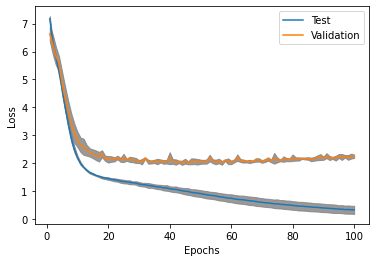

In [168]:
ms_nb.plot_cv(loss, val_loss, epochs=epochs)

In [19]:
2.01 - 0.068

1.9419999999999997

In [176]:
hot_benchmark = build_dnn_hot([54])
hot_benchmark.fit([x_train_hot, xdrug_train_hot], y_train_hot, epochs=56, batch_size=4)

Epoch 1/56
 20/645 [..............................] - ETA: 3s - loss: 9.3404 - mae: 2.6350 

2022-07-21 17:59:30.511640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


645/645 [==============================] - 3s 5ms/step - loss: 7.1313 - mae: 2.1219
Epoch 2/56
645/645 [==============================] - 3s 5ms/step - loss: 6.3153 - mae: 1.9570
Epoch 3/56
645/645 [==============================] - 3s 5ms/step - loss: 5.7239 - mae: 1.8564
Epoch 4/56
645/645 [==============================] - 3s 5ms/step - loss: 4.9918 - mae: 1.7196
Epoch 5/56
645/645 [==============================] - 3s 5ms/step - loss: 4.1657 - mae: 1.5406
Epoch 6/56
645/645 [==============================] - 3s 5ms/step - loss: 3.3696 - mae: 1.3625
Epoch 7/56
645/645 [==============================] - 3s 5ms/step - loss: 2.7008 - mae: 1.2046
Epoch 8/56
645/645 [==============================] - 3s 5ms/step - loss: 2.2284 - mae: 1.0924
Epoch 9/56
645/645 [==============================] - 3s 5ms/step - loss: 1.9982 - mae: 1.0316
Epoch 10/56
645/645 [==============================] - 3s 5ms/step - loss: 1.8216 - mae: 0.9827
Epoch 11/56
645/645 [==============================] - 3s 5m

# Model seleciton
Uses and tests functions from my model_selection module 

In [191]:
epochs = 75
loss, val_loss, *_ = ms_nb.run_cv(build_test_dnn, 
                                  [x_train, xdrug_train],
                                  y_train,
                                  [64],
                                  batch_size=4,
                                  k=3,
                                 epochs=epochs)

0.0


2022-07-26 10:30:35.549952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-26 10:30:37.747707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.3333333333333333


2022-07-26 10:33:36.193869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-26 10:33:38.318327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.6666666666666666


2022-07-26 10:36:37.167244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-26 10:36:39.638985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(2.7013458410898843, 0.049, 47)


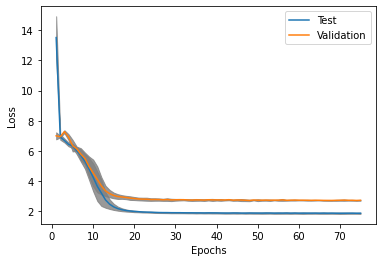

In [18]:
ms_nb.plot_cv(loss, val_loss, epochs=epochs)

## Hyper param opt
using run_random_hp_opt function

In [139]:
def build_test_dnn(hps):
    '''Build neural network with keras
    
    Input hps as a dict
    '''
    num_hps = 1
    #check number of hyper prams in arg and needed matches
    assert len(hps) == num_hps 
    num_uni = hps['num_uni']
    
    phos_input = layers.Input(shape=x_train.shape[1])
    x = layers.Dense(num_uni, activation='relu')(phos_input)
    drug_input = layers.Input(shape = (x_drug.shape[1]))
    concatenated = layers.concatenate([x, drug_input])
    hidd = layers.Dense(num_uni // 2, activation='relu')(concatenated)
    output_tensor = layers.Dense(1)(hidd)
    model = tf.keras.models.Model([phos_input,drug_input], output_tensor)
    model.compile(
        optimizer='rmsprop',
        loss=tf.keras.metrics.mean_squared_error,
        metrics=['mae'])
    return model

In [169]:
num_trails = 3
epochs = 10
hp_grid = {'num_uni': [32, 64, 128]}

opt_r, *_ = ms_nb.run_random_hp_opt(ParameterGrid(hp_grid),
                                    [x_train, xdrug_train],
                                    y_train,
                                   num_trails,
                                   build_test_dnn,
                                   epochs,
                                   batch_size=4)

0.0


2022-07-25 16:00:54.983970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:00:57.271794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:01:20.704941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:01:22.981534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:01:46.798203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:01:49.099135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.3333333333333333


2022-07-25 16:02:13.008358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:02:15.115236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:02:36.914097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:02:39.025725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:03:00.588738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:03:02.710154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.6666666666666666


2022-07-25 16:03:24.271819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:03:26.408584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:03:48.463042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:03:50.643115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:04:12.726638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-25 16:04:14.959838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [183]:
from collections import namedtuple
Results = namedtuple('tr',['rt', 'ft', 'xy' ])

r = Results(1,2,3)
r

tr(rt=1, ft=2, xy=3)

In [181]:
r

tr(rt=1, ft=2)

In [170]:
opt_r

,Smallest val loss,SD,Epoch,HPs
0,3.172888,0.131,9,{'num_uni': 128}
1,5.726405,0.825,9,{'num_uni': 32}
2,5.025207,0.763,9,{'num_uni': 64}


# Model testing
Uses and tests functions from my testing module 

In [11]:
dnn_test = build_test_dnn([5])
dnn_test.fit([x_train, xdrug_train], y_train, epochs=5, batch_size=1)

Metal device set to: Apple M1 Pro


2022-07-21 14:30:13.506872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-21 14:30:13.507067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-21 14:30:14.091347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-21 14:30:14.093747: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-21 14:30:14.233485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5
2580/2580 [==============================] - 14s 6ms/step - loss: 7.0393 - mae: 2.0878
Epoch 2/5
2580/2580 [==============================] - 14s 6ms/step - loss: 6.7872 - mae: 2.0509
Epoch 3/5
2580/2580 [==============================] - 15s 6ms/step - loss: 6.7784 - mae: 2.0451
Epoch 4/5
2580/2580 [==============================] - 14s 6ms/step - loss: 6.6767 - mae: 2.0351
Epoch 5/5
2580/2580 [==============================] - 15s 6ms/step - loss: 6.6502 - mae: 2.0297


-9.7939622449161

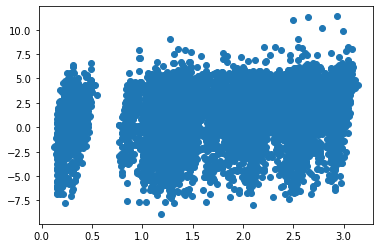

In [73]:
dnn_pre = dnn_test.predict([x_test, xdrug_test])
dnn_pre = dnn_pre.reshape(len(dnn_pre))
plt.scatter(dnn_pre, y_test)
r2_score(dnn_pre, y_test)

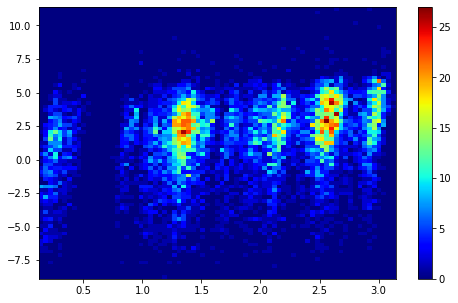

-9.7939622449161

In [74]:
fig, ax = plt.subplots(figsize=(8, 5))
pcm = ax.hist2d(dnn_pre.reshape(len(dnn_pre)), y_test, bins=75, cmap=plt.cm.jet)
fig.colorbar(pcm[3])
plt.show()
r2_score(dnn_pre, y_test)

In [82]:
cl_results = t_nb.sort_results(dnn_pre, y_test, all_cls_drugs[test_inds], centered=0)
drug_results = t_nb.sort_results(dnn_pre, y_test, all_cls_drugs[test_inds], centered=1)

## Benchmark models testing

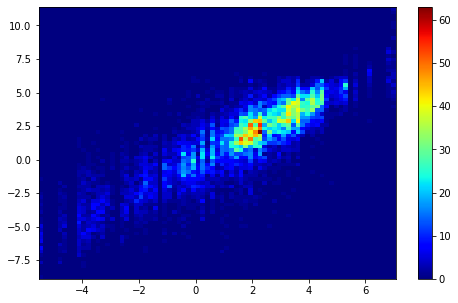

0.6207346568169885

In [120]:
#mean model 
fig, ax = plt.subplots(figsize=(8, 5))
pcm = ax.hist2d(mm_pre, y_test, bins=75, cmap=plt.cm.jet)
fig.colorbar(pcm[3])
plt.show()
r2_score(mm_pre, y_test)

In [118]:
mm_pre = np.array([mean_model[d] for d in test_drugs])
cl_results_mm = t_nb.sort_results(mm_pre, y_test, all_cls_drugs[test_inds], centered=0)
drug_results_mm = t_nb.sort_results(mm_pre, y_test, all_cls_drugs[test_inds], centered=1)

2022-07-21 18:03:53.600574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


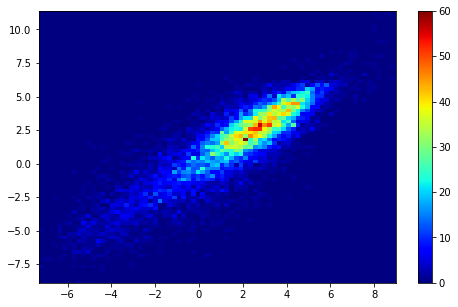

0.6914179934031619

In [177]:
#one hot encoded model
hot_pre = hot_benchmark.predict([x_test_hot, xdrug_test_hot])
hot_pre = hot_pre.reshape(len(hot_pre))

fig, ax = plt.subplots(figsize=(8, 5))
pcm = ax.hist2d(hot_pre, y_test_hot, bins=75, cmap=plt.cm.jet)
fig.colorbar(pcm[3])
plt.show()
r2_score(hot_pre, y_test_hot)

## Compare mean model with real model

In [127]:
def find_centric_statstic(result, statstic):
    '''for drug or cell line centric results finds a test statstic
    
    '''
    statstic_results = {}
    for key in result.keys():
        pre = result[key][0]
        true = result[key][1]
        statstic_results[key] = statstic(true, pre)
    return statstic_results

In [138]:
cl_r2 = find_centric_statstic(cl_results, r2_score)
cl_r2_mm = find_centric_statstic(cl_results_mm, r2_score)

drug_r2 = find_centric_statstic(drug_results, r2_score)
drug_r2_mm = find_centric_statstic(drug_results_mm, r2_score)

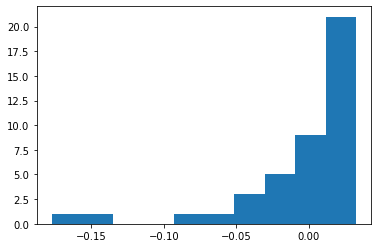

(array([ 3.,  0.,  4.,  1.,  3.,  4.,  7.,  3., 10.,  7.]),
 array([0.38999431, 0.43751477, 0.48503522, 0.53255567, 0.58007613,
        0.62759658, 0.67511703, 0.72263749, 0.77015794, 0.81767839,
        0.86519884]),
 <BarContainer object of 10 artists>)

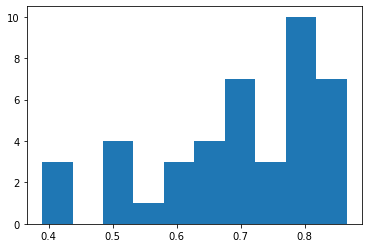

In [137]:
plt.hist(cl_r2.values())
plt.show()
plt.hist(cl_r2_mm.values())

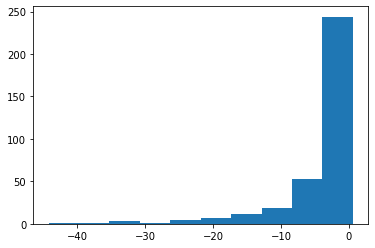

(array([  1.,   1.,   0.,   0.,   2.,   2.,   5.,   6.,  41., 287.]),
 array([-1.54024927e-01, -1.38622434e-01, -1.23219942e-01, -1.07817449e-01,
        -9.24149561e-02, -7.70124635e-02, -6.16099708e-02, -4.62074781e-02,
        -3.08049854e-02, -1.54024927e-02,  2.22044605e-16]),
 <BarContainer object of 10 artists>)

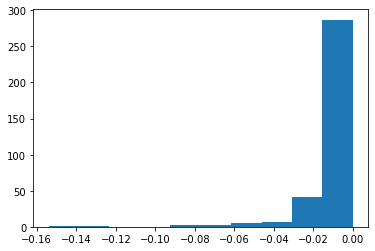

In [139]:
plt.hist(drug_r2.values())
plt.show()
plt.hist(drug_r2_mm.values())